# Early Fusion CO2 AE Labels

## Dataset Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torchvision.transforms as TV
from tqdm.auto import tqdm
import seaborn as sns
import torch.nn as nn
from torch.utils.data import DataLoader

from specseg.core.dataset import SignalAnalysisDataset, SignalMLDataset
from specseg.core.transform import Transform
from specseg.core import visualize as vis
from specseg.transform.co2cross import HFLabel
from specseg.transform.co2cross import HFFeature as CrossFeature
from specseg import helpers

from hydra.core.global_hydra import GlobalHydra
from hydra import compose, initialize
from omegaconf import OmegaConf

from models.backbone import dino
from models.co2 import CO2AE1D03 as CO2Model

sns.set_style("dark")
plt.style.use('dark_background')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

/scratch/gpfs/nc1514/specseg/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


cpu


In [51]:
from transformers import ResNetConfig, ResNetModel

configuration = ResNetConfig()

# Initializing a model (with random weights) from the resnet-50 style configuration
backbone = ResNetModel(configuration)

class CO2AE1D01(nn.Module):

    def __init__(
        self, 
        backbone: nn.Module, 
        n_labels: int, 
        resolution: int,
        ):
        super().__init__()
        
        self.backbone = backbone
        self.n_labels = n_labels
        self.resolution = resolution
        
        hidden_size = backbone.config.hidden_sizes[-1]
        out_size = n_labels * resolution

        self.head = nn.Sequential(
            nn.Linear(hidden_size, out_size),
        )

    def forward(self, x):

        x = self.backbone(x)
        x = self.head(x.last_hidden_state.mean(dim=(2,3)))
        x = x.view(-1, self.n_labels, self.resolution)
        
        return x
    
model = CO2AE1D01(
    backbone=backbone,
    n_labels=5,
    resolution=150,
)

In [3]:
backbone = dino(2)
model = CO2Model(backbone, 5, 150)
model = model.to(device)

In [5]:
config_name = "co2_small"

if GlobalHydra.instance().is_initialized(): GlobalHydra.instance().clear()
initialize(version_base=None, config_path="config/dataset", job_name="early_fusion_co2")
cfg = compose(config_name=config_name)
cfg = OmegaConf.to_container(cfg, resolve=True)

root_dir = cfg['dataset_cfg']['root_dir']
train_shots = helpers.get_shots(root_dir, 'train')
val_shots = helpers.get_shots(root_dir, 'valid')

cross_inputs = ['r0', 'v1', 'v2', 'v3']
labels = ['lfm','bae','eae', 'rsae', 'tae']

transform = Transform(
    CrossFeature,
    HFLabel,
    cfg=cfg['transform_cfg'],
)

dataset_train = SignalMLDataset(
    stage='train',
    inputs=cross_inputs,
    labels=labels,
    shots=train_shots,
    transform=transform,
    cfg=cfg['dataset_cfg'],
)
dataset_train.setup()

dataset_val = SignalMLDataset(
    stage='valid',
    inputs=cross_inputs,
    labels=labels,
    shots=val_shots,
    transform=transform,
    cfg=cfg['dataset_cfg'],
)
dataset_val.setup()

Transforming Feature and Label
Stage: Train
Batch Inputs: True
Number windows per shot: 18
Number of inputs per shot: 4
Number of shots: 121
Total length of dataset: 2178


Transform successfully applied to the dataset.
Dataset setup complete
Stage: Valid
Batch Inputs: True
Number windows per shot: 18
Number of inputs per shot: 4
Number of shots: 60
Total length of dataset: 1080
Transform successfully applied to the dataset.
Dataset setup complete


In [6]:
import pandas as pd

In [7]:
datpath = Path(dataset_train.cfg['root_dir']) / 'train' / '170805.parquet'

In [8]:
data = pd.read_parquet(datpath).time.values
tstart = data[0] / np.timedelta64(1, 'ms')
tend = data[-1] / np.timedelta64(1, 'ms')

In [9]:
dataset_train.location(110*18+4)

(178631, ['r0', 'v1', 'v2', 'v3'], 4)

In [10]:
dataset_train.transform.transform_label.cfg['nframes'] = model.resolution

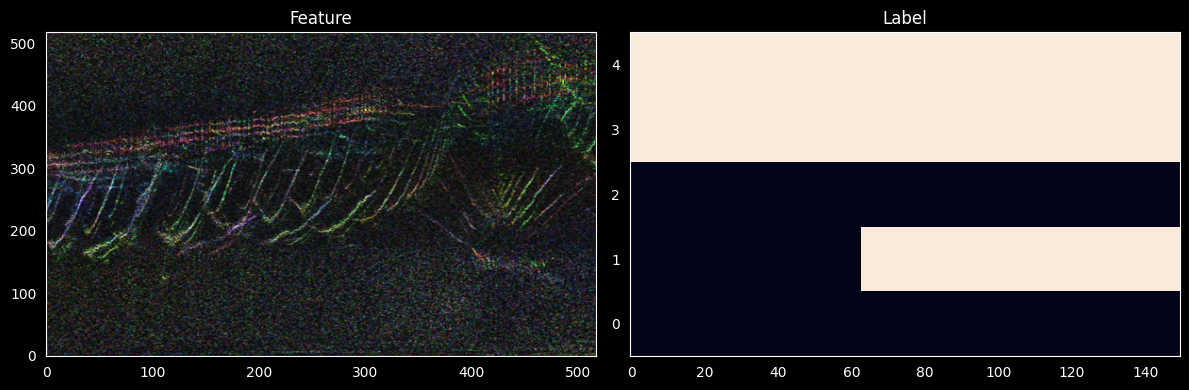

In [39]:
x = dataset_train[110*18+5]
x = (x['features'],x['labels'])
vis.imshow(x, rgb=True)

## Model Setup

In [11]:
import torch.nn.functional as F

In [12]:
def focal_loss(logits, targets, gamma=2.0, alpha=0.25):
    bce = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
    pt  = torch.exp(-bce)
    loss = alpha * (1-pt)**gamma * bce
    return loss.mean()

In [29]:
for p in model.backbone.parameters():
    p.requires_grad = False
    
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.head.parameters())

In [50]:
output.last_hidden_state.mean(dim=(2,3)).shape

torch.Size([1, 2048])

In [46]:
output.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [47]:
output.last_hidden_state.shape

torch.Size([1, 2048, 17, 17])

In [52]:
test_input = torch.randn(1,3,518,518).to(device)
with torch.no_grad():
    output = model(test_input)
# print(output.shape)

In [15]:
batch_size = 32
num_workers = 1
prefetch_factor = 2

loader = DataLoader(
    dataset_train, 
    batch_size=batch_size, 
    num_workers=num_workers,
    prefetch_factor=prefetch_factor,
    shuffle=True, 
    pin_memory=False,
    persistent_workers=True,
    )

print(len(loader))

69


## Training

In [16]:
from IPython.display import clear_output, display

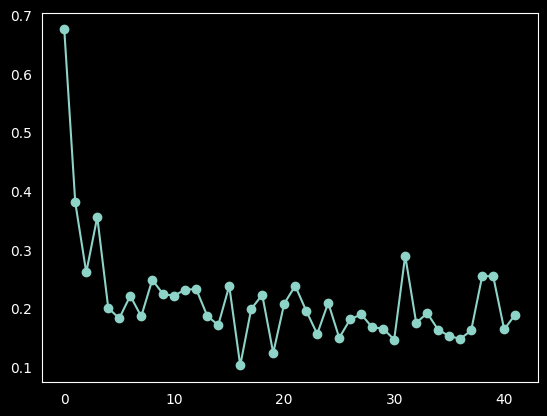

KeyboardInterrupt: 

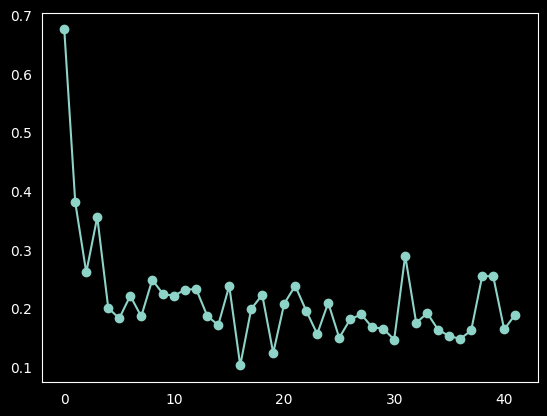

In [17]:
epochs = 3
losses = []

plt.ion()
fig, ax = plt.subplots()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Loss')

for epoch in range(epochs):
    for idx, batch in enumerate(loader):
        optimizer.zero_grad(set_to_none=True)
        feature = batch['features'].to(device)
        label = batch['labels'].to(device)
        prediction = model(feature)
        loss = criterion(prediction, label)
        loss.backward();  optimizer.step()
        
        if idx % 3 == 0: # or 23
            losses.append(loss.item())
            ax.clear()
            ax.plot(losses, marker='o')
            
            # Display updated figure
            clear_output(wait=True)
            display(fig)

In [18]:
torch.save(model.state_dict(), 'mdl.pt')

## Inference

In [17]:
idx = 110*18+19
feature, label = dataset[idx]
feature = feature.unsqueeze(0)
label = label.unsqueeze(0)
with torch.no_grad(): output = model(feature.to(device))
output = torch.sigmoid(output)
output = output.detach().cpu()

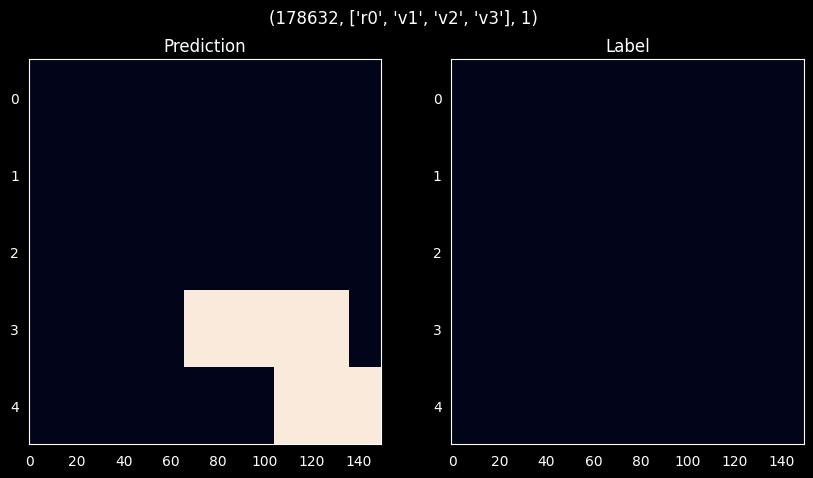

In [18]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(output[0] > 0.5, aspect='auto', interpolation='none')
plt.title('Prediction')
plt.subplot(1,2,2)
plt.imshow(label[0],aspect='auto', interpolation='none')
plt.title('Label')
plt.suptitle(f'{dataset.location(idx)}')
plt.show()

In [19]:
torch.save(model.state_dict(), "model_weights.pth")

In [ ]:
def dice(
    pred: torch.Tensor,
    target: torch.Tensor,
    eps: float = 1e-6
    ):
    """
    pred, target: [B, C, L], binary (0 or 1)
    Returns:
      intersection:   tensor[C]
      pred_sum:       tensor[C]
      target_sum:     tensor[C]
    """
    # sum over batch (0) and length (2) dims → per-class counts
    inter = (pred * target).sum(dim=(0, 2))    # [C]
    p_sum = pred.sum(dim=(0, 2))              # [C]
    t_sum = target.sum(dim=(0, 2))            # [C]
    return inter, p_sum, t_sum

In [23]:
batch_size = 96
num_workers = 3
prefetch_factor = 2

loader = DataLoader(
    dataset, 
    batch_size=batch_size, 
    num_workers=num_workers,
    prefetch_factor=prefetch_factor,
    shuffle=True, 
    pin_memory=True,
    persistent_workers=True,
    )

print(len(loader))

23


In [24]:
model.eval()

C = 5  # number of labels/channels
eps = 1e-6

total_inter = torch.zeros(C, dtype=torch.float64)
total_pred  = torch.zeros(C, dtype=torch.float64)
total_targ  = torch.zeros(C, dtype=torch.float64)

idx = 0

with torch.no_grad():
    for batch in loader:
        clear_output(wait=True)
        print(f"{idx} of {len(loader)}")
        idx += 1
        
        feature = batch[0].to(device)
        label = batch[1].to(device)
        prediction = model(feature)
        prediction = torch.sigmoid(prediction)
        prediction  = (prediction > 0.5).float()
        
        inter, p_sum, t_sum = dice(prediction, label, eps)
        
        total_inter += inter.cpu()
        total_pred  += p_sum.cpu()
        total_targ  += t_sum.cpu()

5 of 23


: 

In [ ]:
dice_per_class = (2 * total_inter + eps) / (total_pred + total_targ + eps)  # [C]
dice_global    = (2 * total_inter.sum() + eps) / (total_pred.sum() + total_targ.sum() + eps)

print(f"full dice: {dice_global:.4f}")
for i, d in enumerate(dice_per_class):
    print(f" {labels[i]} = {d:.4f}")

full dice: 0.5747
 lfm = 0.5933
 bae = 0.4443
 eae = 0.2334
 rsae = 0.6381
 tae = 0.6186


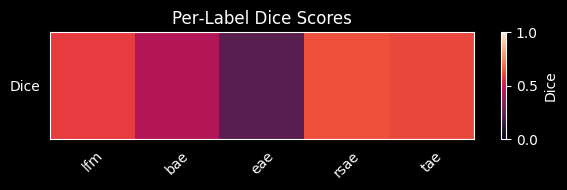

In [ ]:

scores = dice_per_class.numpy()       # [C]
matrix = scores[np.newaxis, :]        # → [1, C]

fig, ax = plt.subplots(figsize=(6,2))
im = ax.imshow(matrix, vmin=0, vmax=1, aspect='auto')
ax.set_yticks([0]);    ax.set_yticklabels(['Dice'])
ax.set_xticks(np.arange(C))
ax.set_xticklabels(labels, rotation=45)
ax.set_title("Per‐Label Dice Scores")
fig.colorbar(im, ax=ax, orientation='vertical', label='Dice')
plt.tight_layout()
plt.show()